# 5.2.2 例題: テレビ番組 "The Price Is Right"の最適化

In [1]:
using Distributed
addprocs(3)

@everywhere using Mamba

In [38]:
using Distributions
using Optim
using Plots

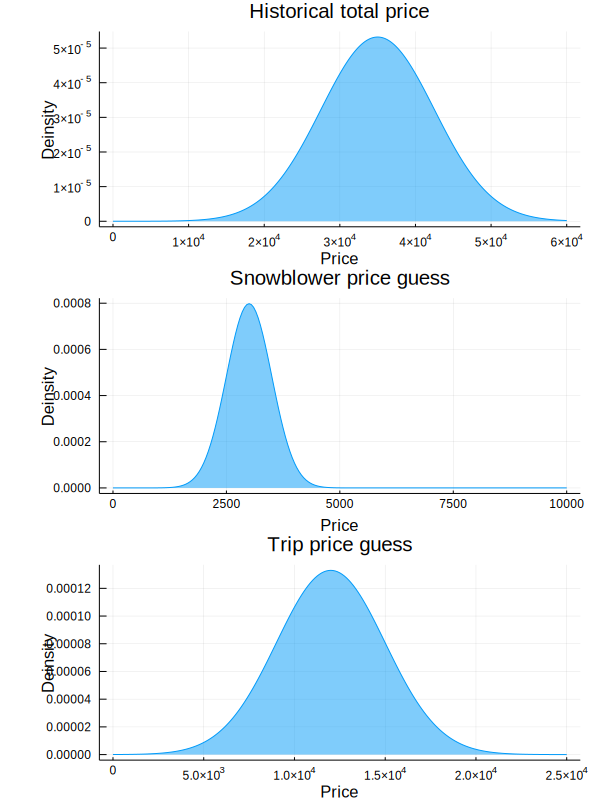

In [3]:
plts = []

x = 0:200:60000
push!(plts, Plots.plot(x, pdf.(Normal(35000, 7500), x),
        fillrange = 0, fillalpha = 0.5, 
        label = "",
        xlabel = "Price", ylabel = "Deinsity", title = "Historical total price"))

x = 0:50:10000
push!(plts, Plots.plot(x, pdf.(Normal(3000, 500), x),
        fillrange = 0, fillalpha = 0.5, 
        label = "",
        xlabel = "Price", ylabel = "Deinsity", title = "Snowblower price guess"))

x = 0:125:25000
push!(plts, Plots.plot(x, pdf.(Normal(12000, 3000), x),
        fillrange = 0, fillalpha = 0.5, 
        label = "",
        xlabel = "Price", ylabel = "Deinsity", title = "Trip price guess"))

Plots.plot(plts..., layout = (3, 1), size = [600, 800])

In [4]:
@everywhere extensions = quote
    using Distributions
    import Distributions: minimum, maximum, logpdf
    
    mutable struct TruePriceDist <: ContinuousUnivariateDistribution
        mu::Float64
        sig::Float64
        price_estimate::Float64
    end
    
    minimum(d::TruePriceDist) = -Inf
    maximum(d::TruePriceDist) = Inf
    
    function logpdf(d::TruePriceDist, x::Real)
       logpdf(Normal(d.mu, d.sig), x) + logpdf(Normal(d.price_estimate, 3000), x)
    end
end

@everywhere eval(extensions)

In [5]:
data = Dict{Symbol, Any}(
    :data_mu => [3e3, 12e3],
    :data_std => [5e2, 3e3],
    :mu_prior => 35e3,
    :std_prior => 75e2,
)

model = Model(
    true_price = Stochastic(
        (mu_prior, std_prior, price_estimate) -> 
        TruePriceDist(mu_prior, std_prior, price_estimate)
        ),
    prize = Stochastic(1, (data_mu, data_std) -> MvNormal(data_mu, data_std)),
    price_estimate = Logical(prize -> sum(prize)),
)

Object of type "Model"
-------------------------------------------------------------------------------
true_price:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
prize:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
price_estimate:
A monitored node of type "ScalarLogical"
NaN


In [6]:
inits = [
    begin
        prize = rand(MvNormal(data[:data_mu], data[:data_std]))
        Dict{Symbol, Any}(
            :true_price => rand(Normal(data[:mu_prior], data[:std_prior])),
            :prize => prize,
            :price_estimate => sum(prize),
        ) 
    end 
    for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:true_price=>35753.6,:prize=>[3199.99, 12441.0],:price_estimate=>15641.0)
 Dict(:true_price=>25552.2,:prize=>[2704.23, 12778.8],:price_estimate=>15483.0)
 Dict(:true_price=>27047.5,:prize=>[3347.95, 10112.4],:price_estimate=>13460.4)

In [7]:
scheme = [AMWG([:true_price, :prize, :price_estimate], 1000)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:true_price, :prize, :price_estimate]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1000), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Int64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1000), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [8]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 50000, burnin = 10000, thin = 3, chains = 3)

MCMC Simulation of 50000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [6:44:35 of 6:44:40 remaining]
      From worker 3:	Chain 3:   0% [6:46:17 of 6:46:22 remaining]
      From worker 4:	Chain 2:   0% [6:54:06 of 6:54:11 remaining]
      From worker 2:	Chain 1:  10% [0:00:50 of 0:00:55 remaining]
      From worker 3:	Chain 3:  10% [0:00:50 of 0:00:55 remaining]
      From worker 4:	Chain 2:  10% [0:00:51 of 0:00:56 remaining]
      From worker 2:	Chain 1:  20% [0:00:24 of 0:00:30 remaining]
      From worker 3:	Chain 3:  20% [0:00:24 of 0:00:30 remaining]
      From worker 4:	Chain 2:  20% [0:00:24 of 0:00:31 remaining]
      From worker 2:	Chain 1:  30% [0:00:17 of 0:00:24 remaining]
      From worker 3:	Chain 3:  30% [0:00:17 of 0:00:24 remaining]
      From worker 4:	Chain 2:  30% [0:00:17 of 0:00:24 remaining]
      From worker 3:	Chain 3:  40% [0:00:12 of 0:00:19 remaining]
      From worker 2:	Chain 1:  40% [0:00:12 of 0:00:19 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10003:49999
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 13333

[2592.45 13237.6 15830.1 21760.3; 3657.3 13237.6 16894.9 20326.8; … ; 3851.5 18127.5 21979.0 17700.2; 3224.88 18127.5 21352.4 17700.2]

[3545.04 20580.4 24125.4 31810.3; 2619.72 20580.4 23200.1 21470.4; … ; 3525.05 13021.8 16546.9 17864.3; 2644.42 13021.8 15666.3 17864.3]

[2668.91 12653.9 15322.8 14634.9; 2638.81 11720.3 14359.1 14793.3; … ; 2862.98 16024.1 18887.1 14879.8; 2863.7 10744.2 13607.9 16681.3]

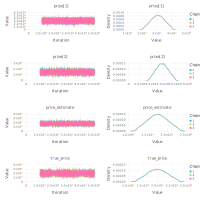

In [9]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 4, ncol = 2)

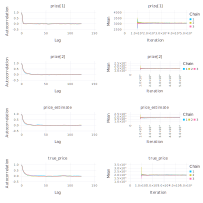

In [10]:
p = Mamba.plot(sim, [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 4, ncol = 2)

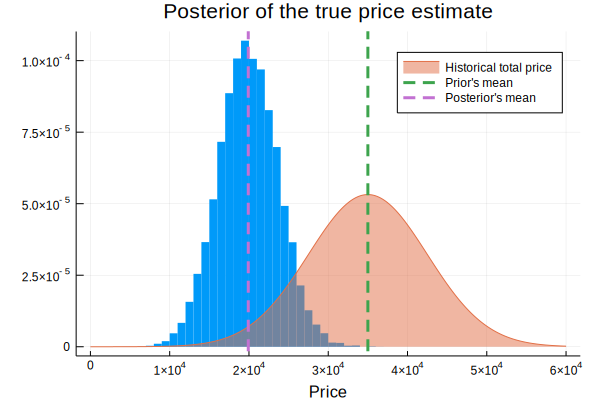

In [11]:
x = 0:200:60000
price_trace = vec(sim[:, :true_price, :].value)
histogram(price_trace, bins = 30, normalize = :pdf,
        linecolor = :transparent, label = "")
Plots.plot!(x, pdf.(Normal(35000, 7500), x),
        fillrange = 0, fillalpha = 0.5, 
        title = "Posterior of the true price estimate",
        label = "Historical total price",
        xlabel = "Price")
vline!([data[:mu_prior]],
    linestyle = :dash, linewidth = 3,
    label = "Prior's mean")
vline!([mean(price_trace)],
    linestyle = :dash, linewidth = 3,
    label = "Posterior's mean")

In [12]:
function showdown_loss(guess, true_price, risk = 80000)
    loss = zeros(length(true_price))
    ix = true_price .< guess
    loss[.!ix] = abs.(guess .- true_price[.!ix])
    close_mask = abs.(true_price .- guess) .<= 250
    loss[close_mask] = -2 * true_price[close_mask]
    loss[ix] .= risk
    loss
end

showdown_loss (generic function with 2 methods)

In [26]:
guesses = 5000:500:30000
risks = 30000:24000:150000

expected_loss(guess, risk) = mean(showdown_loss(guess, price_trace, risk))

expected_loss (generic function with 1 method)

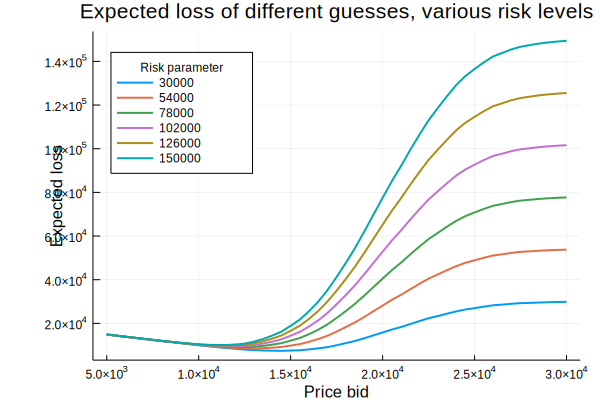

In [36]:
plt = Plots.plot(legendtitle = "Risk parameter", legend = :topleft,
    xlabel = "Price bid", ylabel = "Expected loss",
    title = "Expected loss of different guesses, various risk levels")
for p in risks
    results = expected_loss.(guesses, p) 
    Plots.plot!(guesses, results, label = p, linewidth = 2)
end
plt

minimum at risk 30000: 13898.90551509467
minimum at risk 54000: 12654.398791210526
minimum at risk 78000: 12125.850016784701
minimum at risk 102000: 11460.428148759214
minimum at risk 126000: 11460.428047284533
minimum at risk 150000: 11460.428024358334


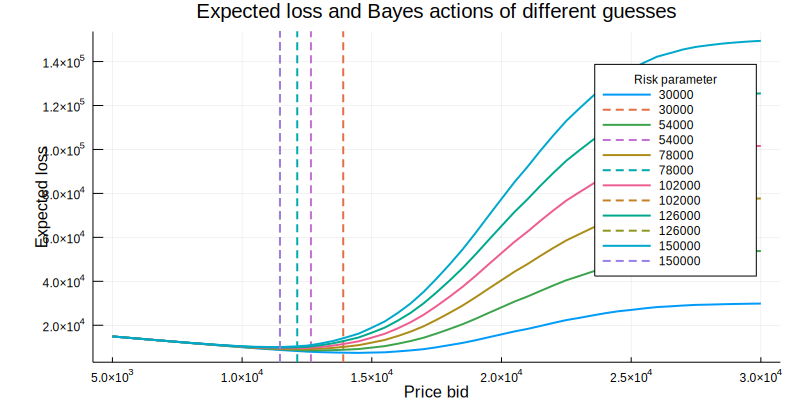

In [53]:
plt = Plots.plot(size = [800, 400],
    legendtitle = "Risk parameter", legend = :topright,
    xlabel = "Price bid", ylabel = "Expected loss",
    title = "Expected loss and Bayes actions of different guesses")

for p in risks

    results = expected_loss.(guesses, p) 
    Plots.plot!(guesses, results, label = p, linewidth = 2)
    
    f(x) = expected_loss(x, p)
    min_results = Optim.minimizer(optimize(f, 0, 30000))
    println("minimum at risk ", p, ": ", min_results)
    vline!([min_results],
        linestyle = :dash, linewidth = 2,
        label = p)
end
plt